In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 6,          # Title size for axes
    'axes.labelsize': 6,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 6,        # Overall figure title size
})

This file tracks the improvement in SAE architectures when measured on probing

In [2]:
def get_baseline(basetype = 'normal', avg = True):
    if basetype == 'normal':
        path = 'normal_settings/layer12_results.csv'
    else:
        path = f'{basetype}/all_results.csv'
    df = pd.read_csv(f'results/baseline_probes_gemma-2-2b/{path}')
    if basetype == 'ood':
        df['method'] = 'logreg'
        df = df.rename(columns={'test_auc_baseline': 'test_auc'})
    df = df[df['method'] == 'logreg']
    if avg and not basetype in ['normal', 'ood']:
        avg_over = {
            'imbalance': 'ratio',
            'scarcity': 'num_train',
            'corrupt': 'ratio'
        }
        toavg = avg_over[basetype]
        if avg and not basetype == 'normal':
            # Group by everything except toavg and the metrics we want to average
            group_cols = [col for col in df.columns if col not in [toavg, 'test_f1', 'test_acc', 'test_auc', 'val_auc']]
            df = df.groupby(group_cols).agg({
                'test_f1': 'mean',
                'test_acc': 'mean', 
                'test_auc': 'mean',
                'val_auc': 'mean'
            }).reset_index()
    return df

df = get_baseline('ood') #
df


,dataset,test_auc,method
0,66_living-room,0.840489,logreg
1,87_glue_cola,0.720000,logreg
2,73_control-group,0.774667,logreg
3,7_hist_fig_ispolitician,0.640759,logreg
4,90_glue_qnli,0.587467,logreg
5,6_hist_fig_isamerican,0.909422,logreg
6,67_social-security,0.913111,logreg
7,5_hist_fig_ismale,0.975211,logreg


In [4]:
def model_dates():
    # Create mapping with release dates and names
    mapping = {
        'relu_google_gemma-2-2b_standard': (pd.to_datetime('2023-10-04'), 'ReLU (orig.)'), #https://transformer-circuits.pub/2023/monosemantic-features
        'standard_new_width-2pow14_date-0107': (pd.to_datetime('2024-04-26'), 'ReLU (new)'), #https://transformer-circuits.pub/2024/april-update/index.html
        'gated_width-2pow14_date-0107': (pd.to_datetime('2024-05-01'), 'Gated'), #https://arxiv.org/abs/2404.16014
        'top_k_width-2pow14_date-0107': (pd.to_datetime('2024-06-06'), 'TopK'),#https://arxiv.org/abs/2406.04093v1
        'jump_relu_width-2pow14_date-0107': (pd.to_datetime('2024-07-19'), 'Jump ReLU'), #https://arxiv.org/abs/2407.14435v1
        'batch_top_k_width-2pow14_date-0107': (pd.to_datetime('2024-07-19'), 'Batch TopK'), #https://www.alignmentforum.org/posts/Nkx6yWZNbAsfvic98/batchtopk-a-simple-improvement-for-topk-saes
        'p_anneal_width-2pow14_date-0107': (pd.to_datetime('2024-07-31'), 'p-anneal'), #https://arxiv.org/abs/2408.00113
        'matryoshka_batch_top_k_width-2pow14_date-0107': (pd.to_datetime('2024-12-19'), 'Matryoshka'), #https://www.lesswrong.com/posts/rKM9b6B2LqwSB5ToN/learning-multi-level-features-with-matryoshka-saes
    }
    
    # Sort by date to determine color order
    sorted_items = sorted(mapping.items(), key=lambda x: x[1][0])
    n_colors = len(mapping)
    colors = plt.cm.viridis(np.linspace(0, 1, n_colors))
    
    # Add colors to mapping
    result = {}
    for i, (key, (date, name)) in enumerate(sorted_items):
        # Convert RGBA array to hex color string
        hex_color = '#%02x%02x%02x' % tuple(int(255*x) for x in colors[i][:3])
        result[key] = (date, name, hex_color)
        
    return result

def read_sae(basetype):
    mapping = {'normal': 'normal_setting', 'scarcity': 'scarcity_setting', 'corrupt': 'label_noise_setting', 'imbalance': 'class_imbalance_setting', 'ood': 'ood_setting'}
    df = pd.read_csv(f'results/sae_probes_gemma-2-2b/{mapping[basetype]}/all_metrics.csv')
    dates = model_dates()
    df['date'] = df['sae_id'].map(lambda x: dates[x][0])
    df['sae_nickname'] = df['sae_id'].map(lambda x: dates[x][1])
    df['color'] = df['sae_id'].map(lambda x: dates[x][2])
    return df


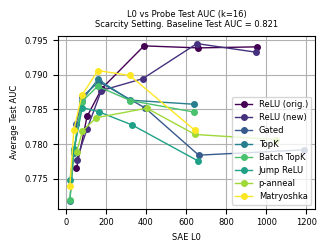

In [8]:
def plot_L0_auc(filterk = 1, basetype = 'normal'):
    # given a regime and a size k probe to construct
    # plots the probing performance of all sae 
    # architecture probes as a function of L0
    df = read_sae(basetype=basetype)
    df = df.sort_values('date')
    plt.figure(figsize=(3.25,2.5))
    for sae_id in df['sae_nickname'].unique():
        sae_df = df[(df['sae_nickname'] == sae_id) & (df['k'] == filterk)]
        l0s = sorted(sae_df['sae_l0'].unique())
        aucs = []
        for l0 in l0s:
            l0_df = sae_df[sae_df['sae_l0'] == l0]
            aucs.append(l0_df['test_auc'].mean())
        color = l0_df['color'].unique()[0]
        plt.plot(l0s, aucs, 'o-', label=sae_id, linewidth=1, markersize=4, color=color)
    baseline_auc = get_baseline(basetype = basetype)['test_auc'].mean()
    #plt.axhline(baseline_auc, linestyle = '--',label = 'LogReg Baseline', color = 'k')
    plt.xlabel('SAE L0')
    plt.ylabel('Average Test AUC')
    plt.title(f'L0 vs Probe Test AUC (k={filterk})\n{basetype.title()} Setting. Baseline Test AUC = {baseline_auc:.3f}')
    plt.legend(fontsize = 6)
    plt.grid(True)
    plt.tight_layout()
    os.makedirs('figures/improvements/normal', exist_ok = True)
    plt.savefig(f'figures/improvements/normal/line_plotl0_k={filterk}.png', dpi = 300, bbox_inches = 'tight')
    plt.savefig(f'figures/improvements/normal/line_plotl0_k={filterk}.pdf', bbox_inches = 'tight')
    plt.show()
def plot_all_L0_auc():
    for k in [16,128]:
        for basetype in ['normal', 'scarcity', 'imbalance', 'corrupt', 'ood']:
            plot_L0_auc(k, basetype)
#plot_all_L0_auc()
plot_L0_auc(filterk = 16, basetype = 'scarcity')

# Fig. 21

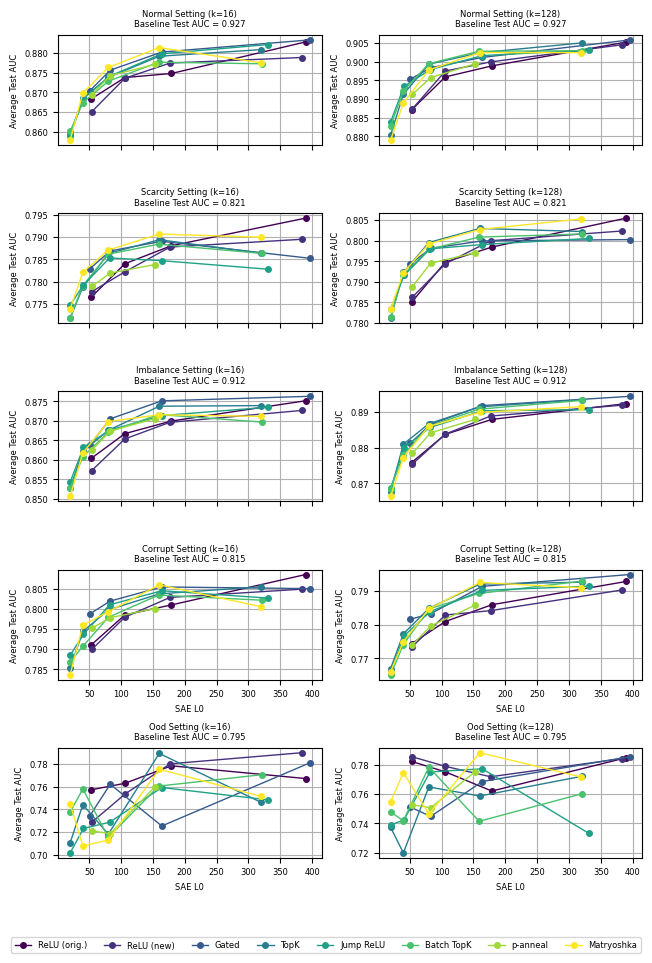

In [9]:
def plot_L0_auc_grid(max_l0 = 400):
    # we plot sae architectures as a function of L0
    # in all settings for k = 16,128
    basetypes = ['normal', 'scarcity', 'imbalance', 'corrupt', 'ood']
    filterks = [16, 128]
    fig, axs = plt.subplots(len(basetypes), len(filterks), figsize=(6.5, 9))
    
    # Store legend handles and labels
    legend_handles = []
    legend_labels = []
    
    for row, basetype in enumerate(basetypes):
        for col, filterk in enumerate(filterks):
            df = read_sae(basetype=basetype)
            df = df.sort_values('date')
            
            for sae_id in df['sae_nickname'].unique():
                sae_df = df[(df['sae_nickname'] == sae_id) & (df['k'] == filterk)]
                l0s = sorted(sae_df['sae_l0'].unique())
                aucs = []
                for l0 in l0s:
                    l0_df = sae_df[sae_df['sae_l0'] == l0]
                    aucs.append(l0_df['test_auc'].mean())
                color = l0_df['color'].unique()[0]
                l0s_filtered = [l0 for l0 in l0s if l0 < max_l0]
                aucs_filtered = [aucs[i] for i in range(len(l0s)) if l0s[i] < max_l0]
                line = axs[row,col].plot(l0s_filtered, aucs_filtered, 'o-', label=sae_id, linewidth=1, markersize=4, color=color)
                
                # Only store legend info from first plot
                if row == 0 and col == 0:
                    legend_handles.append(line[0])
                    legend_labels.append(sae_id)
            
            baseline_auc = get_baseline(basetype=basetype)['test_auc'].mean()
            
            # Only show x-axis labels for bottom row
            if row < 3:
                axs[row,col].set_xticklabels([])
            else:
                axs[row,col].set_xlabel('SAE L0')
                
            axs[row,col].set_ylabel('Average Test AUC')
            axs[row,col].set_title(f'{basetype.title()} Setting (k={filterk})\nBaseline Test AUC = {baseline_auc:.3f}')
            axs[row,col].grid(True)

    # Add single legend at bottom
    fig.legend(legend_handles, legend_labels, loc='center', bbox_to_anchor=(0.5, -0.05), 
              ncol=len(legend_labels), fontsize=6)
    
    plt.tight_layout()
    plt.savefig('figures/improvements/L0_grid.png', dpi=300, bbox_inches='tight')
    plt.savefig('figures/improvements/L0_grid.pdf', bbox_inches='tight')
    plt.show()

plot_L0_auc_grid()

# Plot boxplot of improvement 
Fig. 12

In [10]:
def get_best_l0(sae_nickname, filterk, basetype = 'normal'):
    df = read_sae(basetype = basetype)
    sae_df = df[(df['sae_nickname'] == sae_nickname) & (df['k'] == filterk)]
    l0s = sorted(sae_df['sae_l0'].unique())
    
    # Find L0 with highest average test AUC
    l0_aucs = []
    for l0 in l0s:
        l0_df = sae_df[sae_df['sae_l0'] == l0]
        l0_aucs.append((l0, l0_df['test_auc'].mean()))
    best_l0, _ = max(l0_aucs, key=lambda x: x[1])
    return best_l0


/tmp/ipykernel_2673229/1131256592.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(sae_diffs, labels=sae_names, showfliers=False)


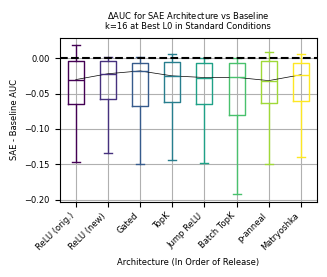

In [11]:
def plot_boxplot_auc_by_sae(filterk=16):
    plt.figure(figsize=(3.25,2.75))

    df = read_sae(basetype = 'normal')
    df = df.sort_values('date')
    baseline_auc = get_baseline(basetype = 'normal')
    # Store diffs for each SAE
    sae_diffs = []
    sae_names = []
    sae_colors = []
    
    for sae_nick in df['sae_nickname'].unique():
        best_l0 = get_best_l0(sae_nick, filterk)
        
        # Get data for best L0
        best_df = df[(df['sae_nickname'] == sae_nick) & (df['k'] == filterk) & (df['sae_l0'] == best_l0)]
        
        # Calculate diffs between SAE and baseline for each dataset
        diffs = []
        for dataset in best_df['dataset'].unique():
            sae_auc = best_df[best_df['dataset'] == dataset]['test_auc'].values
            base_auc = baseline_auc[baseline_auc['dataset'] == dataset]['test_auc'].values
            if len(sae_auc) > 0 and len(base_auc) > 0:
                diff = sae_auc - base_auc
                diffs.extend(diff)
        
        if len(diffs) > 0:
            sae_diffs.append(diffs)
            sae_names.append(sae_nick)
            sae_colors.append(best_df['color'].iloc[0])
    
    # Create boxplot with no outliers and custom colors for all elements
    bp = plt.boxplot(sae_diffs, labels=sae_names, showfliers=False)

    # Color all elements of each box
    for i, color in enumerate(sae_colors):
        plt.setp(bp['boxes'][i], color=color)
        plt.setp(bp['caps'][i*2:i*2+2], color=color)
        plt.setp(bp['whiskers'][i*2:i*2+2], color=color)
        plt.setp(bp['medians'][i], color=color)
    
    # Draw dashed line at y=0
    plt.axhline(y=0, color='black', linestyle='--')
    
    # Get and plot means
    means = [np.median(diffs) for diffs in sae_diffs]
    plt.plot(range(1, len(means) + 1), means, '-', color='black', linewidth=0.5)
    
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Architecture (In Order of Release)')
    plt.ylabel('SAE - Baseline AUC')
    
    plt.title(rf'$\Delta$AUC for SAE Architecture vs Baseline'+f'\nk={filterk} at Best L0 in Standard Conditions')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/improvements/normal/boxplot_k={filterk}.png', dpi=300)
    plt.savefig(f'figures/improvements/normal/boxplot_k={filterk}.pdf')
    plt.show()

plot_boxplot_auc_by_sae()